In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Muon_Decay as MD
import Meta_Muon_Decay as MMD
import numba as nb
import nu_nu_collisions as coll
from coll_varbins import C_short
import Constants as co
import Collision_approx as ca
import var_code_temp as vc

[ 1.22805741e-11  2.24673124e-03  4.94116280e-03  6.25711786e-03
  6.18821976e-03  5.43929059e-03  4.31002417e-03  3.22714920e-03
  2.32498203e-03  1.63129175e-03  1.12322888e-03  7.62832052e-04
  5.12822671e-04  3.42120085e-04  2.29994166e-04  1.49007648e-04
  9.79668259e-05  6.63031378e-05  4.16211711e-05  2.71622612e-05
  1.77279959e-05  1.15827394e-05  7.57944772e-06  4.97169466e-06
  3.27141904e-06  2.16175420e-06  1.43434832e-06  9.56419205e-07
  6.39610660e-07  4.29531134e-07  2.96933534e-07  1.66763127e-06
  1.31107394e-07  8.19017372e-08  5.11056050e-08  3.14223949e-08
  1.93382249e-08  1.16558849e-08  7.02575035e-09  4.54653488e-09
  2.60859855e-09  1.60770073e-09  9.90520795e-10  6.10097097e-10
  3.75685865e-10  2.31287859e-10  1.42361617e-10  8.76100120e-11
  5.39066155e-11  3.31636308e-11  2.03992831e-11  1.25457670e-11
  7.71435231e-12  4.74246747e-12  2.91464670e-12  1.79064856e-12
  1.09961496e-12  6.74912165e-13  4.14025314e-13  2.53877960e-13
  1.55648377e-13  9.54350

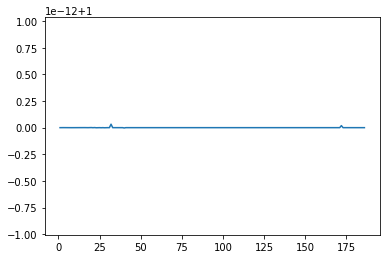

In [42]:
#constants relating to the sterile neutrino:
#D = 1./1.79**3          #a parameter that acts as a fraction of the number density of fermions?


# In[4]:


@nb.jit(nopython=True)
def I1(eps,x): #Energy Density
    numerator = (np.e**eps)*(eps**2)*((eps**2+x**2)**.5)
    denominator = np.e**((eps**2+x**2)**.5)+1
    return numerator/denominator

@nb.jit(nopython=True)
def I2(eps,x): #Pressure
    numerator = (np.e**eps)*(eps**4)
    denominator = ((eps**2+x**2)**.5)*(np.e**((eps**2+x**2)**.5)+1)
    return numerator/denominator

@nb.jit(nopython=True)
def dI1(eps,x): #Derivative of Energy Density
    numerator = (np.e**eps)*((eps**2+x**2)**.5)
    denominator = np.e**((eps**2+x**2)**.5)+1
    return (-x)*numerator/denominator

@nb.jit(nopython=True)
def dI2(eps,x): #Derivative of Pressure
    numerator = (np.e**eps)*3*(eps**2)
    denominator = ((eps**2+x**2)**.5)*(np.e**((eps**2+x**2)**.5)+1)
    return (-x)*numerator/denominator

eps_values, w_values = np.polynomial.laguerre.laggauss(10)

@nb.jit(nopython=True)
def calc_I1(x):
    return np.sum(w_values*I1(eps_values,x)) 

@nb.jit(nopython=True)
def calc_I2(x):
    return np.sum(w_values*I2(eps_values,x))

@nb.jit(nopython=True)
def calc_dI1(x):
    return np.sum(w_values*dI1(eps_values,x)) 

@nb.jit(nopython=True)
def calc_dI2(x):
    return np.sum(w_values*dI2(eps_values,x)) 

def calculate_integral(n,I,x): #n is number of steps to take, I is the function to integrate over, x is me/temp 
    return np.sum(w_values*I(eps_values,x))  



@nb.jit(nopython=True)
def diracdelta(Energy,E0,i,E_array):
    if i==0:
        boxsizeR = E_array[1] - E_array[0]
        boxsizeL = boxsizeR
    elif len(E_array)-i==1:
        boxsizeL = E_array[i] - E_array[i-1]
        boxsizeR = boxsizeL
    else: 
        boxsizeL = E_array[i] - E_array[i-1]
        boxsizeR = E_array[i+1] - E_array[i]
    
    x = E0 - Energy
    if E0 - 0.6 * boxsizeR <= Energy <= E0 - 0.4 * boxsizeR:
        x = E0 - (Energy + 0.5 * boxsizeR)
        A = 0.1 * boxsizeR
        return 2/(boxsizeR + boxsizeL) * (0.5 + 0.75 / A**3 * (x**3 / 3 - A**2 * x))
    elif E0 - 0.4 * boxsizeR <= Energy <= E0 + 0.4 * boxsizeL:
        return 2 / (boxsizeL + boxsizeR)
    elif E0 + 0.4 * boxsizeL <= Energy <= E0 + 0.6 * boxsizeL:
        x = E0 - (Energy - 0.5 * boxsizeL)
        A = 0.1 * boxsizeL
        return 2/(boxsizeR + boxsizeL) * (0.5 - 0.75 / A**3 * (x**3 / 3 - A**2 * x))
    else:
        return 0
    

@nb.jit(nopython=True)
def diracdelta2(Energy,Emin,Emax,E_B,gammaL,v,i,E_array): #E_array is the energy array, i is the index of the box we're at now
    #defining boxsizeL and boxsizeR:
    if i==0:
        boxsizeR = E_array[1] - E_array[0]
        boxsizeL = boxsizeR
    elif len(E_array)-i==1:
        boxsizeL = E_array[i] - E_array[i-1]
        boxsizeR = boxsizeL
    else: 
        boxsizeL = E_array[i] - E_array[i-1]
        boxsizeR = E_array[i+1] - E_array[i]
        
    r = 1/(2 * gammaL * v * E_B)
    if Emin - 0.5*boxsizeR <= Energy <= Emin:
        return r * (Energy + boxsizeR - Emin - 0.5 * boxsizeR) * 2 / (boxsizeR + boxsizeL)
    elif Emin <= Energy <= Emin + 0.5*boxsizeL:
        return r * (Energy + boxsizeR - Emin - 0.5 * boxsizeR) * 2 / (boxsizeR + boxsizeL)
    elif Emin + 0.5*boxsizeL <= Energy <= Emax - 0.5 * boxsizeR:
        return r
    elif Emax - 0.5* boxsizeR <= Energy <= Emax:
        return r * (Emax - (Energy-boxsizeL) - 0.5 * boxsizeL) * 2 / (boxsizeR + boxsizeL)
    elif Emax <= Energy <= Emax + 0.5*boxsizeL:
        return r * (Emax - (Energy - boxsizeL) - 0.5 * boxsizeL) * 2 / (boxsizeR + boxsizeL)
    else:
        return 0
        


@nb.jit(nopython=True)
def pB_other(mA,mB,mC):
    part1 = (mB**2-mA**2-mC**2)/(-2*mA)
    return (part1**2-mC**2)**.5

@nb.jit(nopython=True)
def energyandmomentum(mA,mB,mC,EA,theta): #theta is the angle at which the sterile neutrino decays
    pA = (EA**2-mA**2)**(1/2)
    pBo = pB_other(mA,mB,mC)
    pCo = pBo
    pxB = pBo*np.sin(theta)
    pxC = pCo*np.sin(theta+np.pi)
    pzB = .5*pA + (EA*pBo*np.cos(theta)/mA) + (pA*(mB**2 - mC**2)/(2*mA**2))
    pzC = .5*pA + (EA*pCo*np.cos(theta+np.pi)/mA) + (pA*(mC**2 - mB**2)/(2*mA**2))
    EB = (.5*EA) + (EA*(mB**2 - mC**2)/(2*mA**2)) + (pA*pBo*np.cos(theta)/mA)
    EC = (.5*EA) + (EA*(mC**2 - mB**2)/(2*mA**2)) + (pA*pCo*np.cos(theta+np.pi)/mA)
    return pxB,pxC,pzB,pzC,EB,EC

@nb.jit(nopython=True)
def energyB(mA,mB,mC,EA,theta): #NOTE: I keep putting 0 in for theta because it shouldn't matter yet, but it will soon
    pA = (EA**2-mA**2)**(1/2)
    pBo = pB_other(mA,mB,mC)
    EB = (.5*EA) + (EA*(mB**2 - mC**2)/(2*mA**2)) + (pA*pBo*np.cos(theta)/mA)
    return EB


@nb.jit(nopython=True)
def plasmaenergy(mA,mB,mC,EA,theta): #again, this function assumes that the neutrino is particle B
    pA = (EA**2-mA**2)**(1/2)
    pBo = pB_other(mA,mB,mC)
    pCo = pBo
    EB = (.5*EA) + (EA*(mB**2 - mC**2)/(2*mA**2)) + (pA*pBo*np.cos(theta)/mA)
    EC = (.5*EA) + (EA*(mC**2 - mB**2)/(2*mA**2)) + (pA*pCo*np.cos(theta+np.pi)/mA)
    return EC/(EB+EC) #Returns FRACTION of energy given to the plasma in the decay process


@nb.jit(nopython=True)
def trapezoid(y_array,x_array):
    total = np.sum((x_array[1:]-x_array[:-1])*(y_array[1:]+y_array[:-1])/2)
    return total

#@nb.jit(nopython=True)
def decay2(ms,angle):  #angle is the mixing angle of vs with active neutrinos
    numerator = 9*(co.Gf**2)*co.a_value*(ms**5)*((np.sin(angle))**2)
    denominator = 512*np.pi**4
    gamma = numerator/denominator
    return gamma

#@nb.jit(nopython=True)
def decay5(ms,angle): #angle is the mixing angle of the sterile neutrino with the active neutrinos
    part1 = (co.Gf**2)*(co.f_pi**2)/(16*np.pi)
    part2 = ms*((ms**2)-(co.mpi_neutral**2))*(np.sin(angle))**2
    gamma = part1*part2
    return gamma

#@nb.jit(nopython=True)
def decay6(ms,angle):
    part1 = (co.Gf**2)*(co.f_pi**2)/(16*np.pi)
    parentheses = ((ms**2) - (co.mpi_charged+co.me)**2)*((ms**2) - (co.mpi_charged-co.me)**2)
    part2 = ms * ((parentheses)**(1/2)) * (np.sin(angle))**2
    gamma = part1*part2
    return 2*gamma #because vs can decay into either pi+ and e- OR pi- and e+

#@nb.jit(nopython=True)
def decay7(ms,angle):
    part1 = (co.Gf**2)*(co.f_pi**2)/(16*np.pi)
    parentheses = ((ms**2) - (co.mpi_charged+co.mu)**2)*((ms**2) - (co.mpi_charged-co.mu)**2)
    part2 = ms * ((parentheses)**(1/2)) * (np.sin(angle))**2
    gamma = part1*part2
    return 2*gamma #because vs can decay into either pi+ and u- OR pi- and u+

#@nb.jit(nopython=True)
def tH(ms,angle):
    return 1/(decay2(ms,angle)+decay5(ms,angle)+decay6(ms,angle)+decay7(ms,angle))


# In[6]:


#@nb.jit(nopython=True)



def find_breaks(f, E5_index=0, E2_index=0):
    if (len(np.where(f < f_TINY)[0]) > 0):
        k_0 = np.where(f < f_TINY)[0][0]
    else: 
        k_0 = len(f) - 1
    if (len(np.where(f < f_MINI)[0]) > 0):
        k_1 = np.where(f < f_MINI)[0][0]
    else:
        k_1 = len(f) - 1
    if (len(np.where(f < f_SMALL)[0]) > 0):
        k_2 = np.where(f < f_SMALL)[0][0]
    else:
        k_2 = len(f) - 1
    
    for i in range(k_0, len(f)):
        if f[i] > f_TINY:
            k_0 = i+1
    for i in range(k_1,len(f)):
        if f[i] > f_MINI:
            k_1 = i+1
    for i in range(k_2,len(f)):
        if f[i] > f_SMALL:
            k_2 = i+1
            
    Echeck = [E5_index, E2_index]
    k_return = [k_0, k_1, k_2]
    for j in range(3):
        for i in range(2):
            if Echeck[i] - MIN_eps_BUFFER < k_return[j] <= Echeck[i]:
                k_return[j] += 2 * MIN_eps_BUFFER
            if Echeck[i] <= k_return[j] < Echeck[i] + MIN_eps_BUFFER:
                k_return[j] += MIN_eps_BUFFER
        for jj in range(j+1,3):
            if k_return[jj] < k_return[j] + MIN_eps_BUFFER:
                k_return[jj] = k_return[j] + MIN_eps_BUFFER
        if k_return[j] >= len(f):
            k_return[j] = len(f) - 1
    return k_return

# In[44]:


# This function assumes T_initial * a_initial = 1
# here, e_array is a required input.  Boxsize is calculated from that.
####################################################
##  12/28/20: include intermediate saves as optional
#def driver(ms,mixangle,a_init,y_init, e_array, eps_small, eps_buffer, dx, N_steps = 10, dN_steps = 10, pl_last = False, first = False, temp_fin=0):

@nb.jit(nopython=True)
def nH(time,Tcm,tao,D): #number density of decaying particles
    part1 = D*3*1.20206/(2*np.pi**2)
    part2 = Tcm**3*np.e**(-time/tao)
    return part1*part2
    
#@nb.jit(nopython=True)
def C_ve(p_array, Tcm, T, f,A_model,n_model):
    C_array = p_array**n_model * (f - ca.f_eq(p_array, T, 0))
    return - A_model * ca.n_e(T) * co.Gf**2 * T**(2-n_model) * C_array

    
#@nb.jit(nopython=True)
def f(a,y,p): #y is a vector with length 102 for now, y[-2] is temp and y[-1] is time, the rest are prob functions for now
    
    d_array = np.zeros(len(y))
    Tcm = 1/a #We always need T_initial * a_initial = 1
    T=y[-2]
    lene=int(p[-10])
    e_array=p[:lene]
    time=y[-1]
    fe=y[:lene]
    ms=p[-1]
    tao=p[-2]
    D=p[-3]
    mixangle=p[-4]
    kk=p[-7:-4]
    A_model=p[-8]
    n_model=p[-9]
    
    
    dtda_part2 = 2*np.pi/3
    E_B2 = energyB(ms,0,0,ms,0)
    E_B5 = energyB(ms,0,135,ms,0)
    
    #constants referrring to decay 6; the initial decay and the decay of the pion into the muon
    E_pi6 = energyB(ms,co.mpi_charged,co.me,ms,0) #energy of the charged pion from decay 6, theta is 0 because this is our chosen direction
    p_pi6 = (E_pi6**2 - co.mpi_charged**2)**(1/2) #momentum of charged pion from decay 6
    theta = 0
    E_B6 = energyB(co.mpi_charged,0,co.mu,co.mpi_charged,theta) #describes the energy of the muon neutrino from the pion decay from decay 6 in the other frame
    gammapi6 = E_pi6/co.mpi_charged
    v6 = p_pi6/E_pi6
    E_B6max = gammapi6*(E_B6 + (v6*E_B6))
    E_B6min = gammapi6*(E_B6 - (v6*E_B6))
    
    #constants referring to decay 7; the initial decay, the decay of the pion into the muon, and the decay of the FIRST muon 
    E_pi7 = energyB(ms,co.mpi_charged,co.mu,ms,0) #energy of the charged pion from decay 7, theta is 0 because this is our chosen direction
    Eu = ms-E_pi7 #Energy of the FIRST muon from decay 7, contains the rest of the energy that didn't go into the pion
    p_pi7 = (E_pi7**2 - co.mpi_charged**2)**(1/2) #momentum of charged pion from decay 7
    theta = 0
    E_B7 = energyB(co.mpi_charged,0,co.mu,co.mpi_charged,theta) #describes the energy of the muon neutrino from the pion decay from decay 7 in the other frame gammapi7 = E_pi7/c.mpi_charged
    gammapi7 = E_pi7/co.mpi_charged
    v7 = p_pi7/E_pi7
    E_B7max = gammapi7*(E_B7 + (v7*E_B7))
    E_B7min = gammapi7*(E_B7 - (v7*E_B7))
    
    #constants referring to the muon decay in decay 6:
    theta = 0
    E_mu6 = energyB(co.mpi_charged,co.mu,0,co.mpi_charged,theta) #describes the energy of the muon from the pion decay from decay 6 in the other frame
    p_mu6 = (E_mu6**2 - co.mu**2)**(1/2) #momentum of the muon in the other frame
    E_mumin6 = gammapi6*(E_mu6 - (v6*p_mu6))
    E_mumax6 = gammapi6*(E_mu6 + (v6*p_mu6))
    
    #constants referring to the SECOND muon decay in decay 7:
    theta = 0
    E_mu7 = energyB(co.mpi_charged,co.mu,0,co.mpi_charged,theta) #describes the energy of the muon from the pion decay from decay 7 in the other frame
    p_mu7 = (E_mu7**2 - co.mu**2)**(1/2) #momentum of the muon in the other frame
    E_mumin7 = gammapi7*(E_mu7 - (v7*p_mu7))
    E_mumax7 = gammapi7*(E_mu7 + (v7*p_mu7))


    dtda_part1 = co.mPL/(2*a)
    dtda_part3 = (T**4*np.pi**2)/15
    dtda_part4 = 2*T**4*calc_I1(co.me/T)/np.pi**2
    dtda_part6 = ms*nH(time,Tcm,tao,D)
    dtda_part7 = (Tcm**4/(2*np.pi**2))*trapezoid(fe*e_array**3,e_array)
    dtda = dtda_part1/(dtda_part2*(dtda_part3+dtda_part4+dtda_part6+dtda_part7))**.5
    d_array[-1] = dtda

    #df/da for the neutrinos and antineutrinos at epsilon = 0:
    d6b_e0 = 2*(1-co.x0**2)*decay6(ms,mixangle)*gammapi6*(co.mu**2)*(co.Gf**2)*E_mu6*nH(time,Tcm,tao,D)*dtda/(np.pi*MMD.gammanu((co.mu/2)*(1-co.x0**2)))
    d7b_e0 = 2*(1-co.x0**2)*decay7(ms,mixangle)*(Eu/co.mu)*(co.mu**2)*(co.Gf**2)*nH(time,Tcm,tao,D)*dtda/(np.pi*MD.gammanu((co.mu/2)*(1-co.x0**2)))
    d7c_e0 = 2*(1-co.x0**2)*decay7(ms,mixangle)*gammapi7*(co.mu**2)*(co.Gf**2)*E_mu7*nH(time,Tcm,tao,D)*dtda/(np.pi*MMD.gammanu((co.mu/2)*(1-co.x0**2)))
    d_array[0] = d6b_e0+d7b_e0+d7c_e0

    c = C_short(e_array*Tcm,fe,T,kk) 
    c += C_ve(e_array*Tcm, Tcm, T, fe,A_model,n_model)
    c *= dtda
    for i in range (1,lene): #because all the derivatives are dF/da except Temp and Time
        eps = e_array[i]
        coefficient = (2*np.pi**2)/(eps**2*Tcm**2*a**3)
        d2 = (decay2(ms,mixangle)*diracdelta((eps*Tcm),E_B2,i,e_array*Tcm)*nH(time,Tcm,tao,D)*a**3)*dtda
        #print(d2)
        d5 = (decay5(ms,mixangle)*diracdelta((eps*Tcm),E_B5,i,e_array*Tcm)*nH(time,Tcm,tao,D)*a**3)*dtda
        #print(d5)
        d6 = .5*(decay6(ms,mixangle)*diracdelta2((eps*Tcm),E_B6min,E_B6max,E_B6,gammapi6,v6,i,e_array*Tcm)*nH(time,Tcm,tao,D)*a**3)*dtda
        d6b = decay6(ms,mixangle)*(1/(2*gammapi6*v6*p_mu6))*MMD.u_integral(E_mumin6,E_mumax6,eps*Tcm,ms,mixangle)*nH(time,Tcm,tao,D)*a**3*dtda
        #print(d6+d6b)
        d7a = .5*(decay7(ms,mixangle)*diracdelta2((eps*Tcm),E_B7min,E_B7max,E_B7,gammapi7,v7,i,e_array*Tcm)*nH(time,Tcm,tao,D)*a**3)*dtda
        d7b = MD.v(Eu,eps*Tcm,ms,mixangle)*nH(time,Tcm,tao,D)*a**3*dtda #times two because there are 2 neutrinos coming out with the same energy distribution
        d7c = decay7(ms,mixangle)*(1/(2*gammapi7*v7*p_mu7))*MMD.u_integral(E_mumin7,E_mumax7,eps*Tcm,ms,mixangle)*nH(time,Tcm,tao,D)*a**3*dtda
        #print(d7a+d7b+d7c)
        d_array[i] = coefficient*(d2+d5+d6+d6b+d7a+d7b+d7c) + c[i]#neutrinos only, antineutrinos not included

    df_array = d_array[:-2]*e_array**3/(2*np.pi**2) 
    dQda_part1 = ms*nH(time,Tcm,tao,D)*a**3*dtda/tH(ms,mixangle)
    dQda_part2 = Tcm**4*a**3*trapezoid(df_array,e_array)
    dQda = dQda_part1-dQda_part2

    dTda_constant1 = (4*np.pi**2/45)+(2/np.pi**2)*(calc_I1(co.me/T) + (1/3)*(calc_I2(co.me/T)))
    dTda_constant2 = 2*co.me*T*a**3/(np.pi**2)
    dTda_numerator1 = -3*a**2*T**3*dTda_constant1
    dTda_numerator2 = dQda/T
    dTda_denominator = (3*T**2*a**3*dTda_constant1) - (dTda_constant2*(calc_dI1(co.me/T))) - ((1/3)*dTda_constant2*(calc_dI2(co.me/T)))
    dTda = (dTda_numerator1 + dTda_numerator2)/dTda_denominator
    d_array[-2] = dTda
    print(d_array)
    return d_array
aaa=np.load("test_derivatives.npz",allow_pickle=True)
aaa.files
['ms',
 'mixing',
 'lifetime',
 'scale_factor',
 'y_inputs',
 'eps',
 'derivatives',
 'k',
 'An_model']
step=1

p=np.zeros(len(aaa['eps'][step])+10)

p[-10]=len(aaa['eps'][step])
p[:len(aaa['eps'][step])]=aaa['eps'][step]
p[-1]=aaa['ms']
p[-2]=vc.tH(aaa['ms'],aaa['mixing'])
p[-3]=1./1.79**3 
p[-4]=aaa['mixing']
p[-7:-4]=aaa['k'][step][:3]
p[-8]=aaa['An_model'][step][0]
p[-9]=aaa['An_model'][step][1]
check=f(aaa['scale_factor'][1],aaa['y_inputs'][1],p)
real=aaa['derivatives']
yval=np.zeros(len(check))
for i in range(len(check)):
    yval[i]=real[1][i]/check[i]
xval=np.linspace(1,len(check),len(check))
print(yval)
plt.figure()
plt.plot(xval,yval)
plt.show()

In [18]:
print(yval-1)

[ 0.00000000e+00  4.44089210e-16  2.22044605e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  2.22044605e-16  2.22044605e-16 -1.11022302e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.44089210e-16
  0.00000000e+00  0.00000000e+00  2.22044605e-16  8.88178420e-16
 -3.33066907e-16  6.66133815e-16 -8.88178420e-16  0.00000000e+00
  0.00000000e+00 -7.77156117e-16  0.00000000e+00 -8.88178420e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.24185123e-14
  0.00000000e+00  0.00000000e+00  4.44089210e-16 -4.44089210e-16
  0.00000000e+00  2.22044605e-16  0.00000000e+00 -2.88657986e-15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [26]:
der7=[5.791458197179697e-06,
2.0716792144793407e-05,
4.1102440878341187e-05,
6.749215545916106e-05,
0.00011435231908991616,
0.00012907925820791034,
0.00013544244034468012,
0.00013300030185665952,
0.0001265280704635614,
0.00011880634789836622,
0.0001106364929678284,
0.00010235155543636415,
9.406778663938149e-05,
6.946372320617506e-05,
4.7173965679372225e-05,
3.9586839061574815e-05,
3.246297182675938e-05,
2.591788663300814e-05,
2.0067106095315174e-05,
1.4989941135349606e-05,
1.0701822240726926e-05,
7.22253864614071e-06,
4.549220911946998e-06,
2.726223806399816e-06,
1.7308003232364865e-06,
1.1336541460181199e-06,
6.883522265552639e-07,
3.856311797040222e-07,
1.8484307560816726e-07,
7.251556180628346e-08,
1.8269503800332475e-08,
1.311116216930445e-09]

In [27]:
ob7=[6.024981787856908e-06,
2.13604557104343e-05,
4.1897214608040264e-05,
6.774336334818996e-05,
0.00011292963894492636,
0.00012441672168294558,
0.00012617764624207179,
0.00012343820958049653,
0.00011851371223536289,
0.00011238320969929555,
0.00010581885160863884,
9.912447855742006e-05,
9.238713271068742e-05,
6.925614152741586e-05,
4.83368963799706e-05,
4.1988513100775645e-05,
3.59424109937586e-05,
3.0284903547158558e-05,
2.510230420647429e-05,
2.0444714724511664e-05,
1.62983564212912e-05,
1.2653809366848637e-05,
9.478994965456419e-06,
6.7890588695556135e-06,
4.550490685164851e-06,
2.782350867778255e-06,
1.4598941214814492e-06,
5.995024732679111e-07,
1.8617315115881256e-07,
7.251556180628233e-08,
1.8269503800332138e-08,
1.3111162169304471e-09]

In [28]:
for i in range(len(der7)):
    print(der7[i]/ob7[i])

0.9612407806530024
0.9698665808273711
0.9810303921839578
0.9962917712287515
1.0125979340612574
1.037475159784763
1.0734265884531864
1.0774646060458886
1.0676238899029875
1.0571538952861117
1.0455272504468973
1.0325558018151362
1.018191428604642
1.0029973035485529
0.9759411383913291
0.9428016411670347
0.9031940520739294
0.8558021851596702
0.7994129116696603
0.7331939495041133
0.656619720669914
0.5707797894492419
0.4799265036562819
0.40156137378998225
0.38035465688988324
0.40744471128594867
0.47150832134096704
0.6432520246362484
0.9928557069461069
1.0000000000000155
1.0000000000000184
0.9999999999999984


In [29]:
der6=[4.405365284593405e-06,
1.5344432356328176e-05,
2.9401658044231852e-05,
6.989993041875932e-05,
8.400228652650203e-05,
8.835350510095226e-05,
8.865170179329357e-05,
8.66681384604064e-05,
8.380242161022879e-05,
8.07371955122636e-05,
7.753284021753317e-05,
7.422434232256224e-05,
7.084668842385637e-05,
6.743486511789519e-05,
6.402385900112286e-05,
6.0648656669932616e-05,
3.5141037886858365e-05,
2.3353729528844257e-05,
2.0295858131738613e-05,
1.741373690431826e-05,
1.4742352441261389e-05,
1.2316691334069451e-05,
1.017087210180019e-05,
8.309875395745424e-06,
6.702942790156163e-06,
5.338101887599853e-06,
4.173658164389121e-06,
3.206671859840234e-06,
2.405323912130516e-06,
1.750703511326425e-06,
1.23867851710683e-06,
8.31926314517957e-07,
5.331731544321226e-07,
3.1422389799905473e-07,
1.6645775468308766e-07,
7.50763066549559e-08,
2.5343731969450985e-08,
4.349789362524339e-09,
3.66518000156058e-11]

In [30]:
ob6=[4.405365284593403e-06,
1.534443235632817e-05,
2.940165804423184e-05,
6.989993041875936e-05,
8.400228652650199e-05,
8.835350510095222e-05,
8.865170179329354e-05,
8.666813846040634e-05,
8.380242161022877e-05,
8.073719551226353e-05,
7.753284021753311e-05,
7.422434232256221e-05,
7.084668842385631e-05,
6.743486511789516e-05,
6.402385900112283e-05,
6.064865666993259e-05,
3.5141037886858704e-05,
2.3353729528844264e-05,
2.029585813173862e-05,
1.7413736904318264e-05,
1.4742352441261399e-05,
1.2316691334069454e-05,
1.0170872101800185e-05,
8.309875395745419e-06,
6.702942790156158e-06,
5.338101887599852e-06,
4.173658164389117e-06,
3.2066718598402315e-06,
2.4053239121305113e-06,
1.7507035113264242e-06,
1.238678517106826e-06,
8.319263145179545e-07,
5.331731544321202e-07,
3.1422389799905346e-07,
1.6645775468308731e-07,
7.507630665495397e-08,
2.534373196945079e-08,
4.349789362524339e-09,
3.66518000156058e-11]

In [32]:
for i in range(len(der6)):
    print(der6[i]/ob6[i])

1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999994
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000007
1.0000000000000002
1.0000000000000009
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999903
0.9999999999999997
0.9999999999999997
0.9999999999999998
0.9999999999999993
0.9999999999999998
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000002
1.000000000000001
1.0000000000000009
1.000000000000002
1.0000000000000004
1.000000000000003
1.000000000000003
1.0000000000000047
1.000000000000004
1.000000000000002
1.0000000000000258
1.0000000000000078
1.0
1.0


In [34]:
array_der=[ 1.22805741e-11,  2.10600541e-03,  4.84419177e-03,  6.20390164e-03,
  6.17875834e-03,  5.47358397e-03,  4.38807235e-03 , 3.34109091e-03,
  2.41501799e-03 , 1.69091653e-03 , 1.16193595e-03 , 7.86825471e-04,
  5.26327524e-04 , 3.48112952e-04 , 2.30632394e-04  ,1.45892962e-04,
  9.23133292e-05 , 5.90478533e-05 , 3.34987985e-05 , 1.87569770e-05,
  9.51011610e-06 , 3.93516670e-06 , 8.17074543e-07 ,-6.44140960e-07,
 -9.79176219e-07, -5.56965577e-07, -3.53802017e-08,  3.18633135e-07,
  4.75219115e-07 , 4.28578067e-07 , 2.96933534e-07 , 1.66763127e-06,
  1.31107394e-07,  8.19017372e-08 , 5.11056050e-08 , 3.14223949e-08,
  1.93382249e-08 , 1.16558849e-08,  7.02575035e-09,  4.54653488e-09,
  2.60859855e-09  ,1.60770073e-09 , 9.90520795e-10 , 6.10097097e-10,
  3.75685865e-10 , 2.31287859e-10 , 1.42361617e-10,  8.76100120e-11,
  5.39066155e-11 , 3.31636308e-11 , 2.03992831e-11,  1.25457670e-11,
  7.71435231e-12 , 4.74246747e-12,  2.91464670e-12 , 1.79064856e-12,
  1.09961496e-12,  6.74912165e-13,  4.14025314e-13 , 2.53877960e-13,
  1.55648377e-13 , 9.54350612e-14 , 5.85263724e-14 , 3.58894341e-14,
  2.20047864e-14 , 1.34898127e-14,  8.26865872e-15,  5.06765101e-15,
  3.10544064e-15 , 1.90277477e-15 , 1.16573719e-15 , 7.14105181e-16,
  4.37393754e-16 , 2.67875574e-16 , 1.64038208e-16 , 1.00440632e-16,
  6.14932545e-17 , 3.76443852e-17 , 2.30424495e-17 , 1.41030735e-17,
  8.63090931e-18 , 5.28150813e-18 , 3.23160981e-18 , 1.97715352e-18,
  1.20954856e-18 , 7.39892414e-19 , 4.52560939e-19 , 2.76789502e-19,
  1.69272724e-19 , 1.03511809e-19,  6.32934881e-20 , 3.86985813e-20,
  2.36591201e-20 , 1.44633970e-20 , 8.84119205e-21,  5.40406729e-21,
  3.30293987e-21  ,2.01860410e-21 , 1.23359544e-21 , 7.53817162e-22,
  4.60607989e-22 , 2.81429490e-22 , 1.71941586e-22 , 1.05042711e-22,
  6.41689670e-23 , 3.91975360e-23,  2.39423913e-23,  1.46235140e-23,
  8.93124200e-24 , 5.45441610e-24 , 3.33089828e-24 , 2.03400287e-24,
  1.24199320e-24 , 7.58341306e-25,  4.63007902e-25 , 2.82677111e-25,
  1.72572544e-25 , 1.05349391e-25 , 6.43090224e-26 , 3.92546988e-26,
  2.39602623e-26 , 1.46241949e-26 , 8.92551204e-27 , 5.44722583e-27,
  3.32429052e-27 , 2.02863627e-27 , 1.23791635e-27,  7.55371461e-28,
  4.60905897e-28 , 2.81220276e-28 , 1.71578914e-28 , 1.04680155e-28,
  6.38628363e-29 , 3.89597065e-29 , 2.37665973e-29  ,1.44978104e-29,
  8.84345808e-30 , 5.39419120e-30 , 3.29014675e-30 , 2.00673083e-30,
  1.22390610e-30  ,7.46435687e-31 , 4.55220907e-31 , 2.77611661e-31,
  1.69293036e-31 , 1.03234901e-31,  6.29506531e-32 , 3.83848945e-32,
  2.34049140e-32 , 1.42705432e-32 , 8.70083387e-33 , 5.30479163e-33,
  3.23417132e-33 , 1.97171939e-33,  1.20202843e-33 , 7.32777405e-34,
  4.46701326e-34  ,2.72301732e-34 , 1.65986090e-34 , 1.01176874e-34,
  6.16707492e-35 , 3.75894295e-35 , 2.29108350e-35 , 1.39638414e-35,
  8.51055388e-36 , 5.18680357e-36 , 3.16104701e-36 , 1.92642189e-36,
  1.17398153e-36 , 7.15419286e-37 , 4.35963010e-37 , 2.65661334e-37,
  1.61881357e-37 , 9.86404734e-38,  6.01039873e-38 , 3.66219260e-38,
  2.23135498e-38 , 1.35951939e-38 , 8.28305997e-39 , 5.04642564e-39,
  3.07441875e-39 , 1.87294789e-39 , 1.14095359e-39 , 6.33194454e-40,
 -5.80721514e+01 , 2.78139048e+20]

In [35]:
array_ob=[ 1.22805741e-11 , 2.24673124e-03  ,4.94116280e-03 , 6.25711786e-03,
  6.18821976e-03 , 5.43929059e-03  ,4.31002417e-03 , 3.22714920e-03
,  2.32498203e-03  ,1.63129175e-03,  1.12322888e-03 , 7.62832052e-04
,  5.12822671e-04  ,3.42120085e-04  ,2.29994166e-04 , 1.49007648e-04,
  9.79668259e-05,  6.63031378e-05,  4.16211711e-05 , 2.71622612e-05,
  1.77279959e-05 , 1.15827394e-05,  7.57944772e-06,  4.97169466e-06
,  3.27141904e-06,  2.16175420e-06 , 1.43434832e-06 , 9.56419205e-07
,  6.39610660e-07,  4.29531134e-07  ,2.96933534e-07 , 1.66763127e-06,
  1.31107394e-07 , 8.19017372e-08,  5.11056050e-08,  3.14223949e-08,
  1.93382249e-08 , 1.16558849e-08,  7.02575035e-09,  4.54653488e-09
,  2.60859855e-09 , 1.60770073e-09 , 9.90520795e-10 , 6.10097097e-10,
  3.75685865e-10,  2.31287859e-10 , 1.42361617e-10 , 8.76100120e-11
,  5.39066155e-11,  3.31636308e-11,  2.03992831e-11,  1.25457670e-11
,  7.71435231e-12 , 4.74246747e-12  ,2.91464670e-12 , 1.79064856e-12
,  1.09961496e-12 , 6.74912165e-13 , 4.14025314e-13,  2.53877960e-13,
  1.55648377e-13  ,9.54350612e-14,  5.85263724e-14,  3.58894341e-14,
  2.20047864e-14,  1.34898127e-14 , 8.26865872e-15 , 5.06765101e-15
,  3.10544064e-15 , 1.90277477e-15,  1.16573719e-15 , 7.14105181e-16
,  4.37393754e-16 , 2.67875574e-16 , 1.64038208e-16 , 1.00440632e-16
,  6.14932545e-17 , 3.76443852e-17,  2.30424495e-17 , 1.41030735e-17
,  8.63090931e-18 , 5.28150813e-18,  3.23160981e-18,  1.97715352e-18
,  1.20954856e-18,  7.39892414e-19,  4.52560939e-19,  2.76789502e-19
,  1.69272724e-19 , 1.03511809e-19 , 6.32934881e-20,  3.86985813e-20
  ,2.36591201e-20,  1.44633970e-20 , 8.84119205e-21 , 5.40406729e-21
,  3.30293987e-21 , 2.01860410e-21 , 1.23359544e-21 , 7.53817162e-22,
  4.60607989e-22 , 2.81429490e-22 , 1.71941586e-22 , 1.05042711e-22
,  6.41689670e-23 , 3.91975360e-23,  2.39423913e-23 , 1.46235140e-23
,  8.93124200e-24 , 5.45441610e-24,  3.33089828e-24 , 2.03400287e-24
,  1.24199320e-24,  7.58341306e-25,  4.63007902e-25,  2.82677111e-25,
  1.72572544e-25 , 1.05349391e-25 , 6.43090224e-26 , 3.92546988e-26,
  2.39602623e-26 , 1.46241949e-26 , 8.92551204e-27,  5.44722583e-27
,  3.32429052e-27 , 2.02863627e-27 , 1.23791635e-27  ,7.55371461e-28
,  4.60905897e-28  ,2.81220276e-28 , 1.71578914e-28 , 1.04680155e-28
,  6.38628363e-29,  3.89597065e-29 , 2.37665973e-29 , 1.44978104e-29
,  8.84345808e-30,  5.39419120e-30 , 3.29014675e-30 , 2.00673083e-30
,  1.22390610e-30 , 7.46435687e-31 , 4.55220907e-31 , 2.77611661e-31
,  1.69293036e-31 , 1.03234901e-31,  6.29506531e-32 , 3.83848945e-32,
  2.34049140e-32,  1.42705432e-32,  8.70083387e-33,  5.30479163e-33
 , 3.23417132e-33,  1.97171939e-33,  1.20202843e-33 , 7.32777405e-34
,  4.46701326e-34  ,2.72301732e-34 , 1.65986090e-34 , 1.01176874e-34,
  6.16707492e-35 , 3.75894295e-35 , 2.29108350e-35 , 1.39638414e-35,
  8.51055388e-36 , 5.18680357e-36 , 3.16104701e-36 , 1.92642189e-36
 , 1.17398153e-36,  7.15419286e-37 , 4.35963010e-37 , 2.65661334e-37,
  1.61881357e-37 , 9.86404734e-38,  6.01039873e-38 , 3.66219260e-38
,  2.23135498e-38,  1.35951939e-38  ,8.28305997e-39 , 5.04642564e-39
,  3.07441875e-39,  1.87294789e-39,  1.14095359e-39 , 6.33194454e-40,
 -5.80732780e+01 , 2.78139048e+20]

In [41]:
for i in range(len(array_der)):
    print(array_der[i]/array_ob[i])

1.0
0.9373641904761159
0.9803748562990071
0.9914950906806158
0.9984710594699372
1.006304752326167
1.0181085248995252
1.0353072333934854
1.0387254433962227
1.0365506537993587
1.0344605366628394
1.0314530818901668
1.026334352523194
1.017516852306406
1.0027749747356636
0.9790971400340471
0.9422917232638441
0.8905740400720522
0.8048499745361561
0.6905528542667869
0.5364462037133029
0.33974404189737706
0.10780132975176718
-0.12956164930691863
-0.29931238004899546
-0.25764519250153417
-0.024666394631396093
0.3331521714894882
0.7429818555556907
0.9977811457085205
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1

In [39]:
for i in range(len(array_der)):
    print(array_der[i]/real[1][i])

0.9999999968368659
0.9373641922118283
0.9803748567292729
0.991495090192725
0.9984710594801743
1.0063047521116602
1.0181085251331212
1.0353072336704934
1.0387254427545107
1.0365506536725617
1.0344605411344954
1.0314530814647087
1.0263343531390858
1.0175168514533461
1.0027749741289584
0.9790971378595599
0.9422917236763915
0.8905740394243288
0.8048499749365537
0.690552853173619
0.536446204990459
0.3397440411969619
0.10780132968253398
-0.12956164925850186
-0.29931238038762054
-0.25764519197450814
-0.024666394579488615
0.3331521715653007
0.7429818553135917
0.9977811452139985
1.0000000011527028
1.0000000015141628
0.9999999974108804
1.0000000002428653
0.9999999995091644
0.9999999995367832
1.0000000019025614
1.0000000011078471
0.9999999996718633
0.9999999998940468
0.9999999988075057
0.9999999999108445
1.0000000000276033
1.0000000006765908
1.0000000002072726
1.00000000098451
0.9999999979224695
0.9999999998891953
0.9999999994785057
1.0000000010308485
0.9999999996014841
0.9999999976295098
0.99999